In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re

import matplotlib
matplotlib.rcParams["figure.dpi"] = 200

In [2]:
import matplotlib as mpl
cmap = 'Spectral'
num_colors=3
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

1


In [3]:
def extract_val_losses(file_path):
    # Compile a regular expression to match the Val Loss value
    val_loss_pattern = re.compile(r'Val Loss: (\d+\.\d+e[+-]\d+)')
    
    val_losses = []  # List to hold all Val Loss values
    with open(file_path, 'r') as file:
        for line in file:
            # Search for the Val Loss pattern in each line
            match = val_loss_pattern.search(line)
            if match:
                # If a match is found, convert the string to a float and append to the list
                val_losses.append(float(match.group(1)))
    
    # Convert the list of Val Losses to a NumPy array and return it
    return np.array(val_losses)

In [4]:
def extract_KL(file_path):
    # Compile a regular expression to match the Val Loss value
    val_loss_pattern = re.compile(r'snr: (\d+\.\d+e[+-]\d+)')
    
    val_losses = []  # List to hold all Val Loss values
    with open(file_path, 'r') as file:
        for line in file:
            # Search for the Val Loss pattern in each line
            match = val_loss_pattern.search(line)
            if match:
                # If a match is found, convert the string to a float and append to the list
                val_losses.append(float(match.group(1)))
    
    # Convert the list of Val Losses to a NumPy array and return it
    return np.array(val_losses)

In [5]:
def extract_Variances(file_path):
    # Compile a regular expression to match the Val Loss value
    val_loss_pattern = re.compile(r'var\(R\): (\d+\.\d+e[+-]\d+)')
    
    val_losses = []  # List to hold all Val Loss values
    with open(file_path, 'r') as file:
        for line in file:
            # Search for the Val Loss pattern in each line
            match = val_loss_pattern.search(line)
            if match:
                # If a match is found, convert the string to a float and append to the list
                val_losses.append(float(match.group(1)))
    
    # Convert the list of Val Losses to a NumPy array and return it
    return np.array(val_losses)

In [7]:
file_path_ls = ["./Output/vanilla-12233813.out",
                 "./Output/rba_sample-12237762.out",
                 "./Output/vrba_sample-12242956.out"
                 ]
                 
legend_ls    = ["Uniform","RBA",'vRBA']
color_ls     = ["red", "orange",'green']

val_loss_ls = []
Var_ls = []
KL_ls = []

for i in range(len(file_path_ls)):
    file_path = file_path_ls[i]
    val_loss_ls.append(extract_val_losses(file_path))
    Var_ls.append(extract_Variances(file_path))
    KL_ls.append(extract_KL(file_path))

# Loss Convergence

Uniform 0.074147
RBA 0.0062403
vRBA 0.0049651


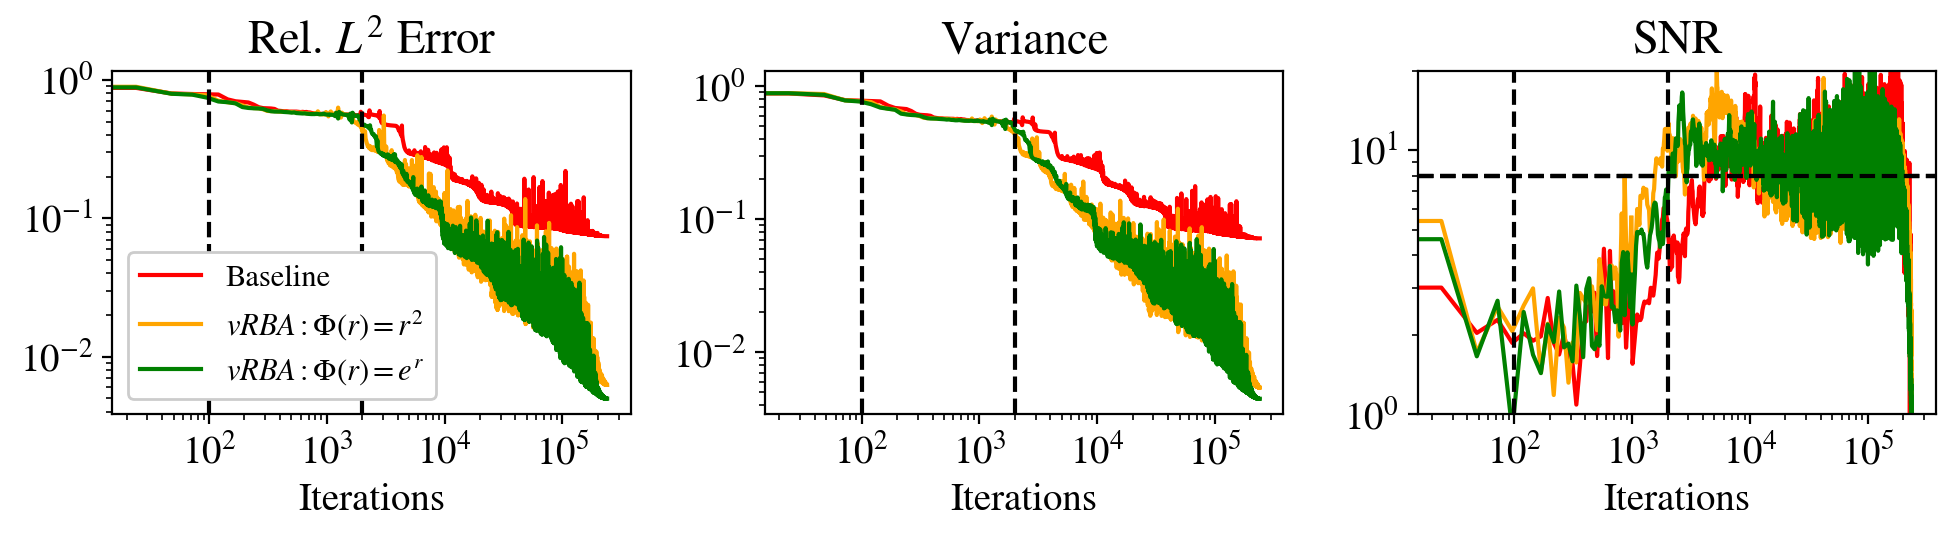

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Note: The variables `legend_ls`, `val_loss_ls`, `Var_ls`, 
# and `KL_ls` are assumed to be defined in your environment.

# Create a figure with one row and three columns, matching the agreed style.
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# --- USER-ADJUSTABLE PARAMETERS ---
moving_average_window = 10
smoothing_start_iter = 1000  # The iteration number to start smoothing from
batch_size_scaler = 24       # The scaler for the x-axis (e.g., batch size)

# Loop through each method/key to plot its results
for i, key in enumerate(legend_ls):
    key_lower = key.lower()
    if 'vrba' in key_lower:
        color = 'green'
        title_plot=rf'$vRBA:\Phi(r)=e^{{r}}$'
    elif 'rba' in key_lower:
        color = 'orange'
        title_plot=rf'$vRBA:\Phi(r)=r^{{2}}$'
    elif 'uniform' in key_lower:
        color = 'red'
        title_plot=rf'Baseline'
    else:
        color = 'gray'
    label = key
    print(key, val_loss_ls[i][-1])
    # --- Plot 1: Relative L^2 Error (Validation Loss) ---
    x_data_loss = np.arange(len(val_loss_ls[i])) * batch_size_scaler
    axes[0].plot(x_data_loss, val_loss_ls[i], label=title_plot, color=color)

    # --- Plot 2: Square Root of Variance ---
    x_data_var = np.arange(len(Var_ls[i])) * batch_size_scaler
    plot_data_var = np.sqrt(np.abs(Var_ls[i]))
    axes[1].plot(x_data_var, plot_data_var, label=title_plot, color=color)

    # --- Plot 3: SNR with a guaranteed continuous transition ---
    x_data_snr = np.arange(len(KL_ls[i])) * batch_size_scaler
    snr_data = np.array(KL_ls[i]) # Ensure it's a numpy array for manipulation

    # Calculate the array index at which to start smoothing
    smoothing_start_index = smoothing_start_iter // batch_size_scaler

    # 1. Plot the initial, unsmoothed part of the data.
    # The label is attached here so it appears only once in the legend.
    axes[2].plot(x_data_snr[:smoothing_start_index + 1], 
                 snr_data[:smoothing_start_index + 1], 
                 label=title_plot, 
                 color=color)

    # 2. Smooth the later part and force a connection.
    if len(snr_data) > smoothing_start_index:
        # Isolate the data segment that needs to be smoothed
        data_to_smooth = snr_data[smoothing_start_index:]
        x_for_smoothing = x_data_snr[smoothing_start_index:]
        
        # Apply the moving average
        smoothed_data = np.convolve(data_to_smooth, np.ones(moving_average_window)/moving_average_window, mode='same')
        
        # **FIX:** Force the smoothed segment to start at the exact point where
        # the raw data segment ended. This eliminates the vertical jump.
        smoothed_data[0] = snr_data[smoothing_start_index]
        
        # Plot the corrected smoothed part (without a label)
        axes[2].plot(x_for_smoothing, smoothed_data, color=color)
        axes[2].axhline(y=8, color='k', linestyle='--')

# --- Formatting and Annotations (from the style template) ---

# Define titles for each subplot
titles = [
    "Rel. $L^2$ Error",
    "Variance",
    "SNR"
]

# Apply formatting to each subplot
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xlabel(r"Iterations")
    ax.axvline(x=100, color='k', linestyle='--')   
    ax.axvline(x=2000, color='k', linestyle='--')   
axes[2].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xscale('log')
axes[2].set_ylim(1,20)

# Add legend only to the first plot
axes[0].legend(fontsize=11, facecolor='white',framealpha=1) #frameon=True)

# Adjust layout to prevent labels from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 1])

# Save and show the figure
plt.savefig("DN_results_connected.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot Results


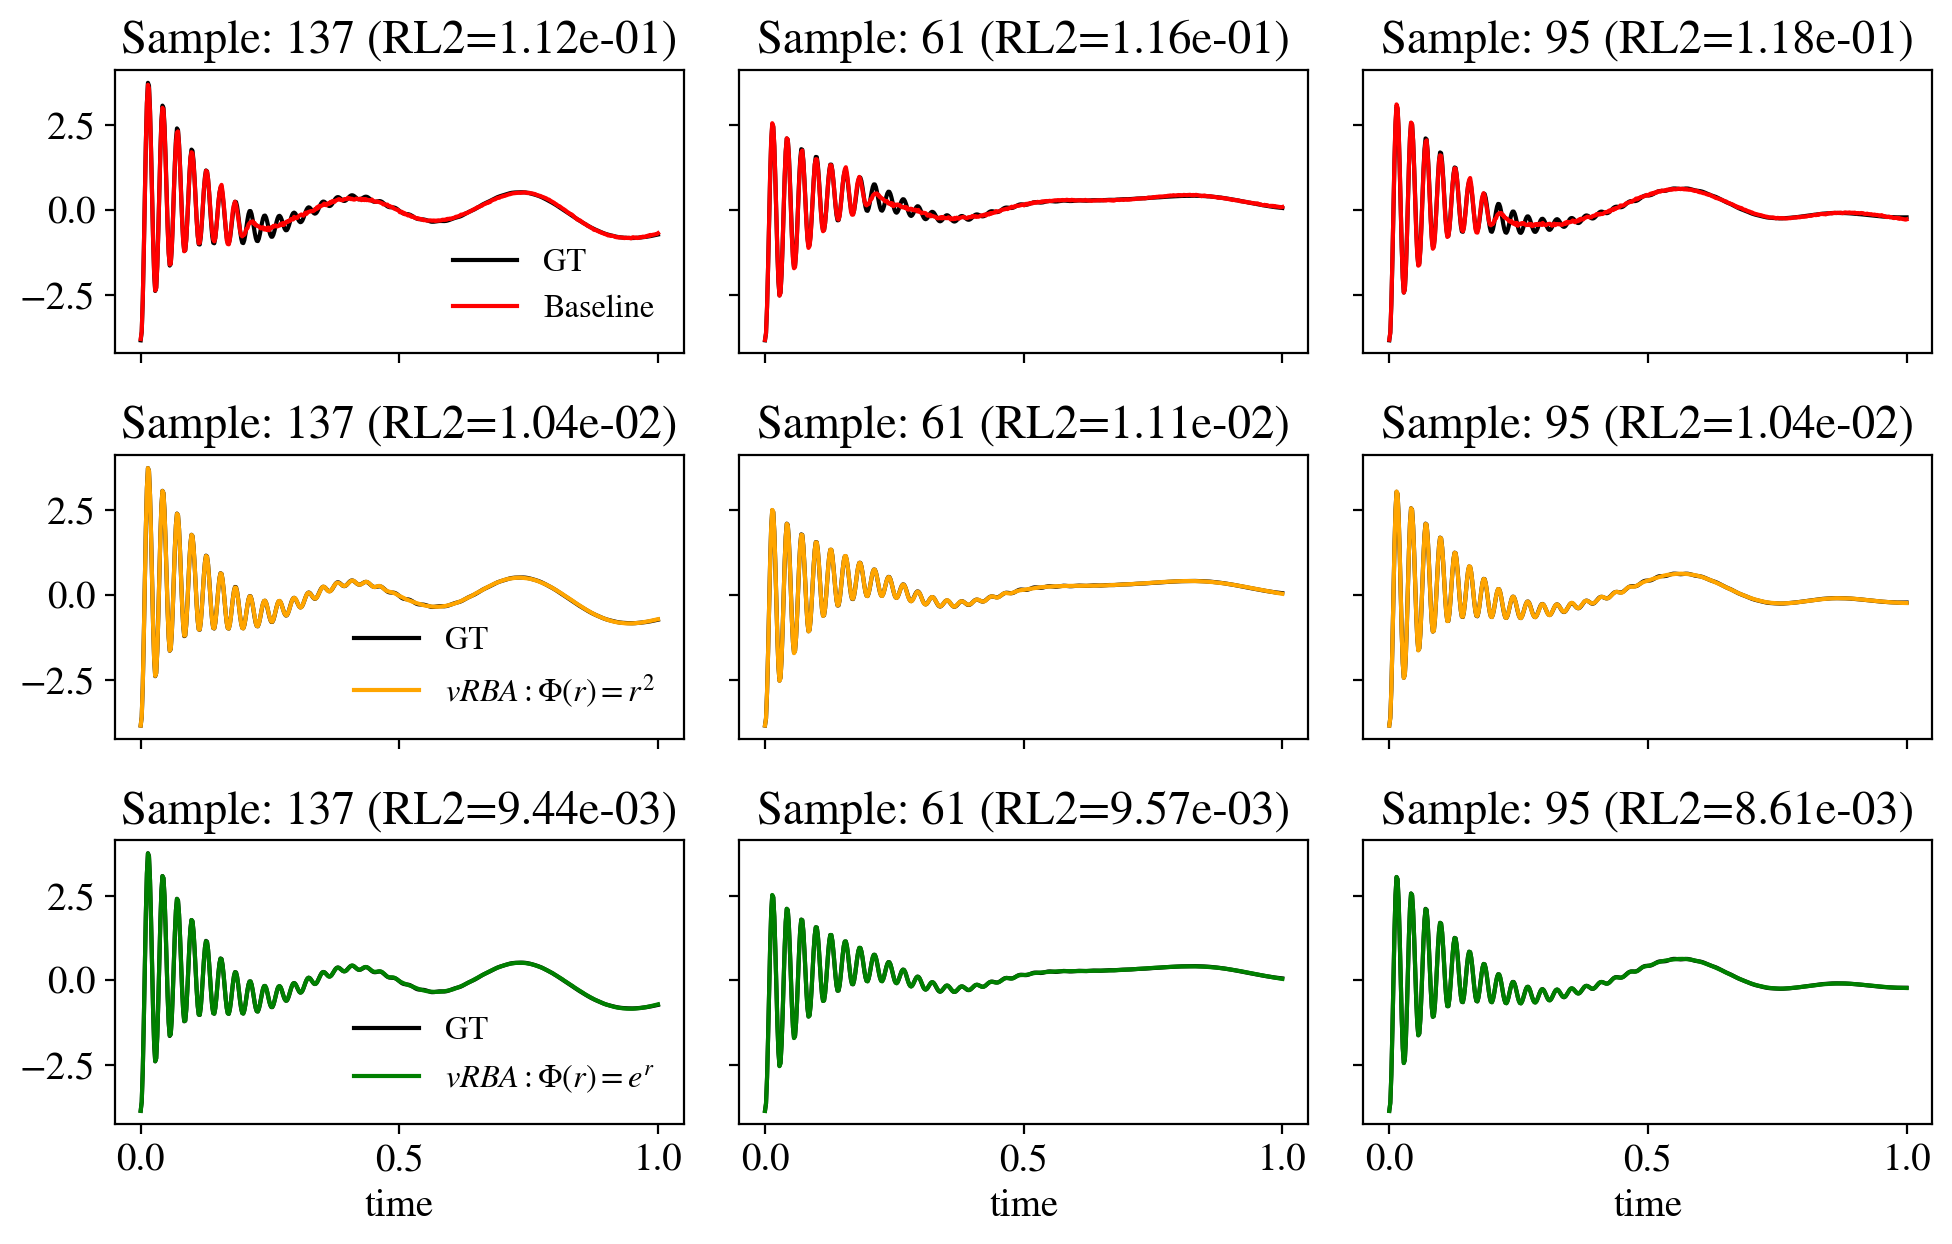

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from your specified paths
try:
    time = np.load("./vanilla/time.npy")
    Y_TRUE = np.load("./vanilla/Y_TRUE.npy")
    Y_PRED = np.load("./vanilla/Y_PRED.npy")
    Y_PRED_rba = np.load("./rba_sample/Y_PRED.npy")
    Y_PRED_vrba = np.load("./vrba_sample/Y_PRED.npy")
except FileNotFoundError as e:
    print(f"Error: {e}. Could not find the data files.")
    print("Please ensure the file paths are correct. Exiting script.")
    exit()


# --- Plotting Setup ---

# Define the models, colors, and labels for plotting
predictions = [Y_PRED, Y_PRED_rba, Y_PRED_vrba]
colors = ['red', 'orange', 'green']
prediction_label = 'Prediction' 
row_titles = ['Baseline', rf'$vRBA:\Phi(r)=r^2$', rf'$vRBA:\Phi(r)=e^r$']

# --- Relative L2 Error Calculation ---
def relative_l2_error(y_true, y_pred):
    """Calculates the relative L2 error."""
    l2_norm_true = np.linalg.norm(y_true)
    if l2_norm_true == 0:
        return np.linalg.norm(y_pred)
    return np.linalg.norm(y_true - y_pred) / l2_norm_true

# --- Find the 3 worst cases for the Uniform model ---

# Calculate errors for all samples of the Uniform model (predictions[0])
num_samples = Y_TRUE.shape[0]
uniform_errors = [relative_l2_error(Y_TRUE[i], Y_PRED[i]) for i in range(num_samples)]

# Get the indices of the 3 samples with the highest error
# np.argsort returns indices that would sort the array in ascending order
# so we take the last 3 indices for the highest values.
worst_indices = np.argsort(uniform_errors)[-3:]

# --- Generate Plots ---

# Create a 3x3 subplot grid
fig, axs = plt.subplots(3, 3, figsize=(10, 7), sharex=True, sharey=True)

# Loop through the rows (models) and columns (worst cases)
for i in range(3):  # Rows for each model
    for j in range(3):  # Columns for each of the 3 worst cases
        current_idx = worst_indices[j]
        
        # Select the true and predicted data for the current subplot
        y_true_slice = Y_TRUE[current_idx]
        y_pred_slice = predictions[i][current_idx]

        # Calculate the relative L2 error for the current plot
        error = relative_l2_error(y_true_slice, y_pred_slice)
        #error =np.mean((y_true_slice-y_pred_slice)**2)

        # Set the title for the subplot with the sample index and error
        axs[i, j].set_title(f'Sample: {current_idx} (RL2={error:.2e})')

        # Plot the ground truth in black
        axs[i, j].plot(time, y_true_slice, 'k', label='GT')
        
        # Plot the prediction with the specified color and style
        axs[i, j].plot(time, y_pred_slice, color=colors[i], linestyle='-', label=row_titles[i])
        
        # Add legend to the first plot of each row
        if j == 0:
            axs[i, j].legend(
                fontsize='small', 
                loc='lower right', 
                ncols=1, 
                frameon=False, 
                facecolor='none'
            )        
        # Set y-label for the first column
        # if j == 0:
        #     axs[i, j].set_ylabel(row_titles[i])
            
        # Set x-label for the last row
        if i == 2:
            axs[i, j].set_xlabel("time",)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("dON_comparison_worst_cases.png",dpi=300)
plt.show()
